In [34]:
import datetime
import re
import pandas as pd
import numpy as np
import json


path_311 = "data/extract.csv"
path_nta = "data/Neighborhood Tabulation Areas.geojson"
path_nta_population = "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv"

In [35]:
df_311 = pd.read_csv(path_311)
print(df_311.shape)
df_311.drop(columns=["X Coordinate (State Plane)", "Y Coordinate (State Plane)"], inplace=True)
df_311.drop(columns="Location", inplace=True)
invalid_complaints = list(df_311["Complaint Type"].value_counts(ascending=True)[
    df_311["Complaint Type"].value_counts(ascending=True) == 1].index)
df_311 = df_311[~df_311["Complaint Type"].isin(invalid_complaints)]
df_311["Created Date"] = pd.to_datetime(df_311["Created Date"])
df_311["Closed Date"] = pd.to_datetime(df_311["Closed Date"])
df_311.drop(df_311[(df_311["Closed Date"] < datetime.datetime(2010, 1, 1)) & (df_311["Status"] == "Closed")].index, inplace=True)
df_311.drop(df_311[df_311["Closed Date"] < df_311["Created Date"]].index, inplace=True)
df_311["Due Date"] = df_311["Due Date"].replace(datetime.datetime(1900, 1, 2), np.NaN)
incorrect_dates = ["10/30/2926 11:51:00 AM", "05/25/2510 10:15:00 AM", "03/06/2927 12:30:00 PM"]
df_311["Resolution Action Updated Date"] = df_311[~df_311["Resolution Action Updated Date"].isin(incorrect_dates)]["Resolution Action Updated Date"]
df_311["Resolution Action Updated Date"] = pd.to_datetime(df_311["Resolution Action Updated Date"])
df_311.drop(df_311[df_311["Resolution Action Updated Date"] > datetime.datetime.today()].index, inplace=True)
df_311.drop(df_311[df_311["Resolution Action Updated Date"] < datetime.datetime(2010, 1, 1)].index, inplace=True)

df_311.shape

c:\program files\python36\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(20000, 41)


(19757, 38)

In [47]:
df_sample = df_311.sample(frac=.25)
print(df_sample.shape)
df_sample.head()

(4939, 38)


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude
6639,23587198,2012-07-10 00:00:00,2012-07-14 00:00:00,HPD,Department of Housing Preservation and Develop...,PLUMBING,WATER-SUPPLY,RESIDENTIAL BUILDING,NaN,219-07 137 STREET,...,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
771,32308912,2015-12-31 13:28:00,2016-01-05 12:00:00,DSNY,BCC - Brooklyn North,Missed Collection (All Materials),1 Missed Collection,Sidewalk,11208,736 SHEPHERD AVENUE,...,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.666454,-73.878185
10262,29661527,2015-01-07 15:21:51,2015-05-14 00:00:00,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,11209,6902 FIFTH AVENUE,...,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.633332,-74.021080
18115,33593755,2016-06-13 17:55:15,2016-06-14 11:30:11,DCA,Department of Consumer Affairs,DCA / DOH New License Application Request,Full Term Mobile Food Unit Permit,NaN,NaN,NaN,...,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1519,25862879,2013-07-02 14:41:21,2013-07-11 00:00:00,DOB,Department of Buildings,General Construction/Plumbing,Excavation Undermining Adjacent Building,NaN,10014,283 WEST 11 STREET,...,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.736021,-74.004749


In [48]:
with open("complaint_type_cls_legend.json") as fp_legend:
    ct_legend = json.load(fp_legend)
ct_legend

{'noise annoyance': 0,
 'private property condition': 1,
 'public utility condition': 2,
 'human activity disturbance': 3,
 'pest': 4,
 'taxation or advantage program related': 5,
 'general/miscellaneous': 99}

In [49]:
with open("complaint_type_cls.json") as fp_data:
    ct_data = json.load(fp_data)
ct_data

{'Noise - Residential': 0,
 'HEAT/HOT WATER': 1,
 'Street Condition': 2,
 'Street Light Condition': 2,
 'Illegal Parking': 3,
 'HEATING': 1,
 'Blocked Driveway': 3,
 'PLUMBING': 1,
 'Water System': 1,
 'GENERAL CONSTRUCTION': 0,
 'Noise': 0,
 'General Construction/Plumbing': 1,
 'Noise - Street/Sidewalk': 0,
 'Traffic Signal Condition': 2,
 'UNSANITARY CONDITION': 1,
 'Sewer': 2,
 'Dirty Conditions': 1,
 'PAINT/PLASTER': 1,
 'Noise - Commercial': 0,
 'PAINT - PLASTER': 1,
 'ELECTRIC': 1,
 'Request Large Bulky Item Collection': 3,
 'Damaged Tree': 2,
 'Sanitation Condition': 1,
 'Rodent': 4,
 'Building/Use': 1,
 'NONCONST': 99,
 'Missed Collection (All Materials)': 3,
 'Noise - Vehicle': 0,
 'Sidewalk Condition': 2,
 'Derelict Vehicles': 2,
 'Derelict Vehicle': 2,
 'DOOR/WINDOW': 1,
 'WATER LEAK': 1,
 'Broken Muni Meter': 2,
 'Consumer Complaint': 3,
 'Taxi Complaint': 3,
 'New Tree Request': 2,
 'GENERAL': 99,
 'Overgrown Tree/Branches': 2,
 'Graffiti': 3,
 'FLOORING/STAIRS': 1,
 'Main

In [50]:
df_sample["Complaint Type Class Index"] = df_sample["Complaint Type"].apply(lambda k: ct_data[k])
ct_legend_inv = {v:k for k, v in ct_legend.items()}
df_sample["Complaint Type Class"] = df_sample["Complaint Type Class Index"].apply(lambda k: ct_legend_inv[k])
df_sample.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Complaint Type Class Index,Complaint Type Class
6639,23587198,2012-07-10 00:00:00,2012-07-14 00:00:00,HPD,Department of Housing Preservation and Develop...,PLUMBING,WATER-SUPPLY,RESIDENTIAL BUILDING,NaN,219-07 137 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,private property condition
771,32308912,2015-12-31 13:28:00,2016-01-05 12:00:00,DSNY,BCC - Brooklyn North,Missed Collection (All Materials),1 Missed Collection,Sidewalk,11208,736 SHEPHERD AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.666454,-73.878185,3,human activity disturbance
10262,29661527,2015-01-07 15:21:51,2015-05-14 00:00:00,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,11209,6902 FIFTH AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.633332,-74.021080,3,human activity disturbance
18115,33593755,2016-06-13 17:55:15,2016-06-14 11:30:11,DCA,Department of Consumer Affairs,DCA / DOH New License Application Request,Full Term Mobile Food Unit Permit,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,taxation or advantage program related
1519,25862879,2013-07-02 14:41:21,2013-07-11 00:00:00,DOB,Department of Buildings,General Construction/Plumbing,Excavation Undermining Adjacent Building,NaN,10014,283 WEST 11 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.736021,-74.004749,1,private property condition


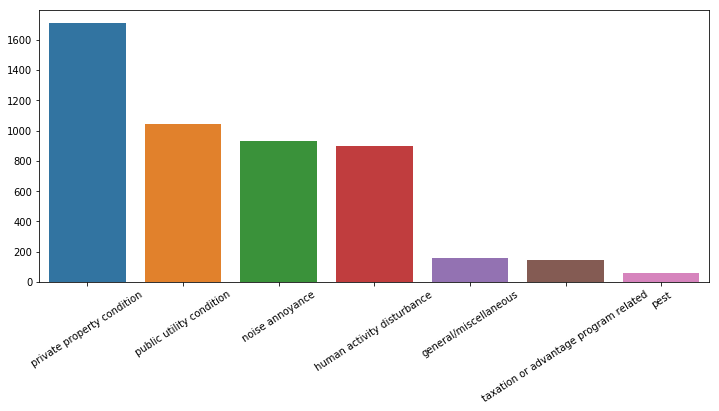

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
ctc_vcounts = df_sample["Complaint Type Class"].value_counts()
ax = sns.barplot(x=ctc_vcounts.index, y=ctc_vcounts.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=33)

ax

In [52]:
df_sample

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Complaint Type Class Index,Complaint Type Class
6639,23587198,2012-07-10 00:00:00,2012-07-14 00:00:00,HPD,Department of Housing Preservation and Develop...,PLUMBING,WATER-SUPPLY,RESIDENTIAL BUILDING,NaN,219-07 137 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,private property condition
771,32308912,2015-12-31 13:28:00,2016-01-05 12:00:00,DSNY,BCC - Brooklyn North,Missed Collection (All Materials),1 Missed Collection,Sidewalk,11208,736 SHEPHERD AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.666454,-73.878185,3,human activity disturbance
10262,29661527,2015-01-07 15:21:51,2015-05-14 00:00:00,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,11209,6902 FIFTH AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.633332,-74.021080,3,human activity disturbance
18115,33593755,2016-06-13 17:55:15,2016-06-14 11:30:11,DCA,Department of Consumer Affairs,DCA / DOH New License Application Request,Full Term Mobile Food Unit Permit,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,taxation or advantage program related
1519,25862879,2013-07-02 14:41:21,2013-07-11 00:00:00,DOB,Department of Buildings,General Construction/Plumbing,Excavation Undermining Adjacent Building,NaN,10014,283 WEST 11 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.736021,-74.004749,1,private property condition
2907,33596550,2016-06-14 09:34:00,2016-06-14 09:55:00,DEP,Department of Environmental Protection,Water System,Hydrant Knocked Over/Missing (WC),NaN,11374,61-01 WOODHAVEN BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,40.729060,-73.871359,1,private property condition
8241,29623566,2015-01-02 09:24:00,2015-01-03 12:00:00,DSNY,BCC - Queens East,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11691,149 BEACH 24 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,40.593894,-73.757765,1,private property condition
466,44061083,2019-10-15 14:49:00,NaT,DOT,Department of Transportation,Street Condition,Defective Hardware,Street,10452,1403 GRAND CONCOURSE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.838963,-73.913637,2,public utility condition
1855,40002753,2018-08-13 08:23:22,2018-09-06 13:44:29,HPD,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,PESTS,RESIDENTIAL BUILDING,11225,1589 BEDFORD AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.668020,-73.956019,1,private property condition
14012,35907570,2017-04-09 18:55:24,2017-04-09 18:55:24,HPD,Department of Housing Preservation and Develop...,GENERAL,SIGNAGE MISSING,RESIDENTIAL BUILDING,11226,2101 BEDFORD AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,40.653121,-73.956079,99,general/miscellaneous


In [53]:

from shapely.geometry import shape, Point
def get_nta(location, ct):
    """Retrieves the NTA of a given location in NYC.
    Args:
        location_str (String): location associated to the complaint, that is '(latitude, longitude)'
    Returns:
        String: code of the NTA the location is part of, or NaN if the location is not within an NTA
    """
    # load GeoJSON file containing NTAs
    with open(path_nta) as f:
        js = json.load(f)

    #location = eval(location_str)
    latitude = location[0]
    longitude = location[1]
    point = Point(longitude, latitude)
    for feature in js["features"]:
        polygon = shape(feature["geometry"])
        if polygon.contains(point):
            nta_code = feature["properties"]["ntacode"]
            ct += [1]
            if len(ct) % 100 == 0: print("Got", len(ct), "NTAs.")
            return nta_code        
    return np.nan


In [54]:

df_sample["Position"] = list(zip(df_sample["Latitude"], df_sample["Longitude"]))
ct = []
df_sample["NTA"] = df_sample["Position"].apply(lambda x: get_nta(x, ct))


Got 100 NTAs.
Got 200 NTAs.
Got 300 NTAs.
Got 400 NTAs.
Got 500 NTAs.
Got 600 NTAs.
Got 700 NTAs.
Got 800 NTAs.
Got 900 NTAs.
Got 1000 NTAs.
Got 1100 NTAs.
Got 1200 NTAs.
Got 1300 NTAs.
Got 1400 NTAs.
Got 1500 NTAs.
Got 1600 NTAs.
Got 1700 NTAs.
Got 1800 NTAs.
Got 1900 NTAs.
Got 2000 NTAs.
Got 2100 NTAs.
Got 2200 NTAs.
Got 2300 NTAs.
Got 2400 NTAs.
Got 2500 NTAs.
Got 2600 NTAs.
Got 2700 NTAs.
Got 2800 NTAs.
Got 2900 NTAs.
Got 3000 NTAs.
Got 3100 NTAs.
Got 3200 NTAs.
Got 3300 NTAs.
Got 3400 NTAs.
Got 3500 NTAs.
Got 3600 NTAs.
Got 3700 NTAs.
Got 3800 NTAs.
Got 3900 NTAs.
Got 4000 NTAs.
Got 4100 NTAs.
Got 4200 NTAs.
Got 4300 NTAs.
Got 4400 NTAs.
Got 4500 NTAs.


In [57]:
df_sample

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Complaint Type Class Index,Complaint Type Class,Position,NTA
6639,23587198,2012-07-10 00:00:00,2012-07-14 00:00:00,HPD,Department of Housing Preservation and Develop...,PLUMBING,WATER-SUPPLY,RESIDENTIAL BUILDING,NaN,219-07 137 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,1,private property condition,"(nan, nan)",NaN
771,32308912,2015-12-31 13:28:00,2016-01-05 12:00:00,DSNY,BCC - Brooklyn North,Missed Collection (All Materials),1 Missed Collection,Sidewalk,11208,736 SHEPHERD AVENUE,...,NaN,NaN,NaN,NaN,40.666454,-73.878185,3,human activity disturbance,"(40.66645388424836, -73.87818481674141)",BK82
10262,29661527,2015-01-07 15:21:51,2015-05-14 00:00:00,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,11209,6902 FIFTH AVENUE,...,NaN,NaN,NaN,NaN,40.633332,-74.021080,3,human activity disturbance,"(40.633332022136884, -74.02108027065545)",BK31
18115,33593755,2016-06-13 17:55:15,2016-06-14 11:30:11,DCA,Department of Consumer Affairs,DCA / DOH New License Application Request,Full Term Mobile Food Unit Permit,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,taxation or advantage program related,"(nan, nan)",NaN
1519,25862879,2013-07-02 14:41:21,2013-07-11 00:00:00,DOB,Department of Buildings,General Construction/Plumbing,Excavation Undermining Adjacent Building,NaN,10014,283 WEST 11 STREET,...,NaN,NaN,NaN,NaN,40.736021,-74.004749,1,private property condition,"(40.736021238997786, -74.00474865660242)",MN23
2907,33596550,2016-06-14 09:34:00,2016-06-14 09:55:00,DEP,Department of Environmental Protection,Water System,Hydrant Knocked Over/Missing (WC),NaN,11374,61-01 WOODHAVEN BOULEVARD,...,NaN,NaN,NaN,NaN,40.729060,-73.871359,1,private property condition,"(40.72906014624229, -73.8713594398413)",QN18
8241,29623566,2015-01-02 09:24:00,2015-01-03 12:00:00,DSNY,BCC - Queens East,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11691,149 BEACH 24 STREET,...,NaN,NaN,NaN,NaN,40.593894,-73.757765,1,private property condition,"(40.59389396758725, -73.7577647689612)",QN15
466,44061083,2019-10-15 14:49:00,NaT,DOT,Department of Transportation,Street Condition,Defective Hardware,Street,10452,1403 GRAND CONCOURSE,...,NaN,NaN,NaN,NaN,40.838963,-73.913637,2,public utility condition,"(40.838963112328955, -73.91363658344284)",BX63
1855,40002753,2018-08-13 08:23:22,2018-09-06 13:44:29,HPD,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,PESTS,RESIDENTIAL BUILDING,11225,1589 BEDFORD AVENUE,...,NaN,NaN,NaN,NaN,40.668020,-73.956019,1,private property condition,"(40.66801959993273, -73.95601877484214)",BK63
14012,35907570,2017-04-09 18:55:24,2017-04-09 18:55:24,HPD,Department of Housing Preservation and Develop...,GENERAL,SIGNAGE MISSING,RESIDENTIAL BUILDING,11226,2101 BEDFORD AVENUE,...,NaN,NaN,NaN,NaN,40.653121,-73.956079,99,general/miscellaneous,"(40.65312095765086, -73.95607905149825)",BK60


In [ ]:
import folium
from folium.plugins import TimestampedGeoJson

COLORS = {
    15: "#ff0000",
    14: "#ee0000",
    13: "#dd0000",
    12: "#cc0000",
    11: "#bb0000",
    10: "#aa0000",
    **{k:"#"+str(k)*2+"0000" for k in range(10)}}
COLORS

get_interp = lambda _min, _max: lambda v: (v-_min)/(_max-_min)*15

def get_df_ntadist(complaint_type_class):    
    test = df_sample["Complaint Type Class"] == complaint_type_class
    df_sample_withyear = df_sample.copy()
    df_sample_withyear["Created year"] = df_sample["Created Date"].apply(lambda ts: ts.year)
    ret_df = pd.DataFrame(df_sample_withyear[test].groupby(
        ["NTA", "Created year"]).count()["Unique Key"])
    ret_df.rename(columns={"Unique Key":"Count"}, inplace=True)
    return ret_df

def map_df_ntadist(df_ntadist, geojson):
    m = folium.Map(location=(40.730610, -73.935242), zoom_start=10)
    
    df_ntadist.reset_index(inplace=True)
    
    features = []
    
    missing = {}
    
    for feature in geojson["features"]:
        
        nta_code = feature["properties"]["ntacode"]
        df_ntacorrect = df_ntadist[df_ntadist["NTA"] == nta_code]
        
        missing[nta_code] = list(df_ntacorrect["Created year"].unique())

        colors = df_ntacorrect["color"]
        years = df_ntacorrect["Created year"]
        
        for i in range(colors.shape[0]):
        #for y in range(MIN_YEAR, MAX_YEAR+1):
            color = colors.iloc[i]
            #color = df_ntacorrect[df_ntacorrect["Created year"] == y]["color"]
            feature["properties"]["style"] = {
                "fillColor": str(color),
                'weight' : 1,
                'fillOpacity' : 0.66,
                'stroke': False
            }
            feature["properties"]["time"] = str(years.iloc[i])
            
            features.append(feature)
    #print(missing)
                    
    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1Y'
        , duration="P1Y"        
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=0.5
        , loop_button=True
        , date_options='YYYY'
        , time_slider_drag_update=True
    ).add_to(m)

    return m

def map_df_ntadist_withempty(df_ntadist, geojson):
    m = folium.Map(location=(40.730610, -73.935242), zoom_start=10)
    
    df_ntadist.reset_index(inplace=True)
    
    features = []
    
    missing = {}
    
    MIN_YEAR = df_ntadist["Created year"].min()
    MAX_YEAR = df_ntadist["Created year"].max()
    
    for feature in geojson["features"]:

        nta_code = feature["properties"]["ntacode"]
        df_ntacorrect = df_ntadist[df_ntadist["NTA"] == nta_code]

        #missing[nta_code] = list(df_ntacorrect["Created year"].unique())

        colors = df_ntacorrect["color"]
        years = df_ntacorrect["Created year"]        

        #for i in range(colors.shape[0]):
        for y in range(MIN_YEAR, MAX_YEAR+1):
            #color = colors.iloc[i]
            df_y = df_ntacorrect[df_ntacorrect["Created year"] == y]
            color = df_y["color"] if df_y.shape[0] > 0 else str("#ff0000")
            feature["properties"]["style"] = {
                "fillColor": str(color),
                'weight' : 1,
                'fillOpacity' : 0.66,
                'stroke': False
            }
            #feature["properties"]["time"] = str(years.iloc[i])
            feature["properties"]["time"] = str(y)           
            features.append(feature)            
                    
    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1Y'
        , duration="P1Y"        
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=0.5
        , loop_button=True
        , date_options='YYYY'
        , time_slider_drag_update=True
    ).add_to(m)

    return m

In [ ]:

df_ntadist = get_df_ntadist("noise annoyance")
MIN = df_ntadist["Count"].min()
MAX = df_ntadist["Count"].max()

# Put intensity of feature as a value between 0 and 15
df_ntadist["min-max-interp"] = df_ntadist["Count"].apply(get_interp(MIN, MAX))

# Cast to integer to get colors
df_ntadist["min-max-interp"] = df_ntadist["min-max-interp"].astype(int)
df_ntadist["color"] = df_ntadist["min-max-interp"].map(COLORS)
def fill_empty_keys(df_nta_ts):
    MIN_YEAR = df_ntadist.index.unique(level="Created year").min()
    MAX_YEAR = df_ntadist.index.unique(level="Created year").max()
    NTAS = df_ntadist.index.unique(level="NTA")
    
    for year in range(MIN_YEAR, MAX_YEAR):
        for nta in NTAS:
            isin = df_nta_ts.index.isin([(nta, year)])
            print(df_nta_ts[isin])

df_ntadist.head()
     

In [ ]:

map_df_ntadist(df_ntadist, geojson)

In [ ]:
import folium
import folium.plugins as plugins
import numpy as np




In [ ]:
CTC = "noise annoyance"
df_ctcmatch = df_sample[df_sample["Complaint Type Class"] == CTC]
df_ctcmatch[]

In [ ]:
years = list(df_ctcmatch["Created Date"].apply(lambda ts: ts.year))
pts = list(zip(df_ctcmatch["Latitude"], df_ctcmatch["Longitude"], [1. for _ in years]))
len(years), len(pts)
years[0]


In [ ]:

m = folium.Map(location=(40.730610, -73.935242), zoom_start=10)
hm = plugins.HeatMapWithTime(
    pts,
    index=years,
    auto_play=False
)
hm.add_to(m)
m

In [ ]:

def map_df_ntadist_year(df_ntadist, geojson, year):
    df = df_ntadist.copy()
    m = folium.Map(location=(40.730610, -73.935242), zoom_start=10)    
    df.reset_index(inplace=True)    
    features = []
    for feature in geojson["features"]:
        
        nta_code = feature["properties"]["ntacode"]
        df_ntacorrect = df[(df["NTA"] == nta_code) & (df["Created year"] == year)]

        colors = df_ntacorrect["color"]
        years = df_ntacorrect["Created year"]
        
        for i in range(colors.shape[0]):
        #for y in range(MIN_YEAR, MAX_YEAR+1):
            color = colors.iloc[i]
            #color = df_ntacorrect[df_ntacorrect["Created year"] == y]["color"]
            feature["properties"]["style"] = {
                "fillColor": str(color),
                'weight' : 1,
                'fillOpacity' : 0.66,
                'stroke': False
            }
            feature["properties"]["time"] = str(years.iloc[i])
            
            features.append(feature)
    #print(missing)
                    
    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1Y'
        , duration="P1Y"        
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=0.5
        , loop_button=True
        , date_options='YYYY'
        , time_slider_drag_update=True
    ).add_to(m)

    return m

def heatmap_df_ntadist_year(df_sample, year):
    df_noise = df_sample[df_sample["Complaint Type Class"] == "noise annoyance"]
    df_noise = df_noise[["Created Date", "Latitude", "Longitude"]]
    df_noise["Created Year"] = df_noise["Created Date"].apply(lambda ts: ts.year)
    df_noise = df_noise[df_noise["Created Year"] == year]
    df_noise.dropna(inplace=True)
    df_noise.drop(columns=["Created Date"], inplace=True)

    points = list(zip(df_noise["Latitude"], df_noise["Longitude"]))
        
    m = folium.Map(location=(40.730610, -73.935242), zoom_start=11)    
    
    hm = plugins.HeatMap(points)
    hm.add_to(m)

    return m

In [ ]:

heatmap_df_ntadist_year(df_sample, 2010)

In [ ]:

heatmap_df_ntadist_year(df_sample, 2019)

In [59]:
df_sample

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Complaint Type Class Index,Complaint Type Class,Position,NTA
6639,23587198,2012-07-10 00:00:00,2012-07-14 00:00:00,HPD,Department of Housing Preservation and Develop...,PLUMBING,WATER-SUPPLY,RESIDENTIAL BUILDING,NaN,219-07 137 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,1,private property condition,"(nan, nan)",NaN
771,32308912,2015-12-31 13:28:00,2016-01-05 12:00:00,DSNY,BCC - Brooklyn North,Missed Collection (All Materials),1 Missed Collection,Sidewalk,11208,736 SHEPHERD AVENUE,...,NaN,NaN,NaN,NaN,40.666454,-73.878185,3,human activity disturbance,"(40.66645388424836, -73.87818481674141)",BK82
10262,29661527,2015-01-07 15:21:51,2015-05-14 00:00:00,DSNY,Department of Sanitation,Graffiti,Graffiti,Mixed Use,11209,6902 FIFTH AVENUE,...,NaN,NaN,NaN,NaN,40.633332,-74.021080,3,human activity disturbance,"(40.633332022136884, -74.02108027065545)",BK31
18115,33593755,2016-06-13 17:55:15,2016-06-14 11:30:11,DCA,Department of Consumer Affairs,DCA / DOH New License Application Request,Full Term Mobile Food Unit Permit,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,taxation or advantage program related,"(nan, nan)",NaN
1519,25862879,2013-07-02 14:41:21,2013-07-11 00:00:00,DOB,Department of Buildings,General Construction/Plumbing,Excavation Undermining Adjacent Building,NaN,10014,283 WEST 11 STREET,...,NaN,NaN,NaN,NaN,40.736021,-74.004749,1,private property condition,"(40.736021238997786, -74.00474865660242)",MN23
2907,33596550,2016-06-14 09:34:00,2016-06-14 09:55:00,DEP,Department of Environmental Protection,Water System,Hydrant Knocked Over/Missing (WC),NaN,11374,61-01 WOODHAVEN BOULEVARD,...,NaN,NaN,NaN,NaN,40.729060,-73.871359,1,private property condition,"(40.72906014624229, -73.8713594398413)",QN18
8241,29623566,2015-01-02 09:24:00,2015-01-03 12:00:00,DSNY,BCC - Queens East,Sanitation Condition,15 Street Cond/Dump-Out/Drop-Off,Street,11691,149 BEACH 24 STREET,...,NaN,NaN,NaN,NaN,40.593894,-73.757765,1,private property condition,"(40.59389396758725, -73.7577647689612)",QN15
466,44061083,2019-10-15 14:49:00,NaT,DOT,Department of Transportation,Street Condition,Defective Hardware,Street,10452,1403 GRAND CONCOURSE,...,NaN,NaN,NaN,NaN,40.838963,-73.913637,2,public utility condition,"(40.838963112328955, -73.91363658344284)",BX63
1855,40002753,2018-08-13 08:23:22,2018-09-06 13:44:29,HPD,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,PESTS,RESIDENTIAL BUILDING,11225,1589 BEDFORD AVENUE,...,NaN,NaN,NaN,NaN,40.668020,-73.956019,1,private property condition,"(40.66801959993273, -73.95601877484214)",BK63
14012,35907570,2017-04-09 18:55:24,2017-04-09 18:55:24,HPD,Department of Housing Preservation and Develop...,GENERAL,SIGNAGE MISSING,RESIDENTIAL BUILDING,11226,2101 BEDFORD AVENUE,...,NaN,NaN,NaN,NaN,40.653121,-73.956079,99,general/miscellaneous,"(40.65312095765086, -73.95607905149825)",BK60


## Getting the formatted dataset

In [94]:
def select_timelapse_df(df_source, complaint_type_class):
    """ Returns: NTA/year/count """
    relevant = df_source.copy()[df_source["Complaint Type Class"] == complaint_type_class]
    relevant["Year"] = relevant["Created Date"].apply(lambda ts: ts.year)
    df_counts = pd.DataFrame(relevant.groupby(
        ["NTA", "Year"]).count()["Unique Key"])
    df_counts.rename(columns={"Unique Key":"Count"}, inplace=True)
    df_counts["Weight"] = df_counts["Count"] / df_counts["Count"].max()
    df_counts.reset_index(inplace=True)
    df_counts["Year"] = df_counts["Year"].astype(np.int64)
    return df_counts

df_counts = select_timelapse_df(df_sample, "noise annoyance")
print(df_counts.shape)
df_counts.head()

(636, 4)


,NTA,Year,Count,Weight
0,BK09,2014,1,0.166667
1,BK09,2017,1,0.166667
2,BK17,2017,2,0.333333
3,BK17,2018,1,0.166667
4,BK19,2017,1,0.166667


## Normalizing
- by capita
- by sq mtr.

In [115]:
TIME_RANGE = range(df_counts["Year"].min(), df_counts["Year"].max())
TIME_RANGE

range(2010, 2019)

#### Capita

We only have population numbers for 2000 and 2010. We will normalize using the last numbers available for each NTA.

In [116]:
df_population = pd.read_csv(path_nta_population)
#df_population = df_population[df_population["Year"].isin(TIME_RANGE)]
df_population.drop_duplicates("NTA Code", inplace=True, keep="last")
df_population.rename(columns={"NTA Code":"NTA"}, inplace=True)
print(df_population.shape)
df_population.head()

(195, 6)


,Borough,Year,FIPS County Code,NTA,NTA Name,Population
195,Bronx,2010,5,BX01,Claremont-Bathgate,31078
196,Bronx,2010,5,BX03,Eastchester-Edenwald-Baychester,34517
197,Bronx,2010,5,BX05,Bedford Park-Fordham North,54415
198,Bronx,2010,5,BX06,Belmont,27378
199,Bronx,2010,5,BX07,Bronxdale,35538


In [117]:
print(df_counts["Year"].dtype, df_population["Year"].dtype)
print(df_counts["NTA"].dtype, df_population["NTA"].dtype)
df_merged = df_counts.merge(df_population, on=["NTA"], how="inner")
df_merged.drop(columns=["FIPS County Code", "Borough", "Year_y"], inplace=True)
df_merged.rename(columns={"Year_x":"Year"}, inplace=True)
print(df_merged.shape)
df_merged.head()

int64 int64
object object
(636, 6)


,NTA,Year,Count,Weight,NTA Name,Population
0,BK09,2014,1,0.166667,Brooklyn Heights-Cobble Hill,22887
1,BK09,2017,1,0.166667,Brooklyn Heights-Cobble Hill,22887
2,BK17,2017,2,0.333333,Sheepshead Bay-Gerritsen Beach-Manhattn Bch,64518
3,BK17,2018,1,0.166667,Sheepshead Bay-Gerritsen Beach-Manhattn Bch,64518
4,BK19,2017,1,0.166667,Brighton Beach,35547


#### Area

In [178]:
with open(path_nta) as f:
    nta_geo = json.load(f)

In [132]:
ntas = [f["properties"]["ntacode"] for f in nta_geo["features"]]
areas = [f["properties"]["shape_area"] for f in nta_geo["features"]]

df_areas = pd.DataFrame(
    index=range(len(nta_geo["features"])), columns=["NTA", "Area"]
)
df_areas["NTA"] = ntas
df_areas["Area"] = areas
df_areas.head()

,NTA,Area
0,BK88,54005018.7472
1,QN51,52488276.477
2,QN27,19726845.26
3,QN07,22887772.7683
4,MN06,10647077.6122


In [141]:
print(df_merged["NTA"].dtype, df_areas["NTA"].dtype)
df_merged2 = df_merged.merge(df_areas, on=["NTA"], how="inner")
#df_merged2.drop(columns=["FIPS County Code", "Borough", "Year_y"], inplace=True)
#df_merged2.rename(columns={"Year_x":"Year"}, inplace=True)
df_merged2["Area"] = df_merged2["Area"].astype(float)
print(df_merged2.shape)
df_merged2.head()

object object
(636, 7)


,NTA,Year,Count,Weight,NTA Name,Population,Area
0,BK09,2014,1,0.166667,Brooklyn Heights-Cobble Hill,22887,9.983620e+06
1,BK09,2017,1,0.166667,Brooklyn Heights-Cobble Hill,22887,9.983620e+06
2,BK17,2017,2,0.333333,Sheepshead Bay-Gerritsen Beach-Manhattn Bch,64518,6.334150e+07
3,BK17,2018,1,0.166667,Sheepshead Bay-Gerritsen Beach-Manhattn Bch,64518,6.334150e+07
4,BK19,2017,1,0.166667,Brighton Beach,35547,1.718014e+07


#### Normalizing weight

In [195]:
df_merged2["Pop Weight"] = df_merged2["Weight"] / df_merged2["Population"]
pw = df_merged2["Pop Weight"]
df_merged2["Pop Weight"] = (pw - pw.min()) / (pw.max() - pw.min())


df_merged2["Area Weight"] = df_merged2["Weight"] / df_merged2["Area"]
aw = df_merged2["Area Weight"]
df_merged2["Area Weight"] = (aw - aw.min()) / (aw.max() - aw.min())

df_merged2.head()
#.hist()

df_merged2[df_merged2["Pop Weight"] > .1]

,NTA,Year,Count,Weight,NTA Name,Population,Area,Area Weight,Pop Weight
192,BK99,2013,1,0.166667,park-cemetery-etc-Brooklyn,418,2.288394e+08,0.002090,1.000000
193,BK99,2014,1,0.166667,park-cemetery-etc-Brooklyn,418,2.288394e+08,0.002090,1.000000
493,MN99,2014,1,0.166667,park-cemetery-etc-Manhattan,1849,9.154335e+07,0.012477,0.223617


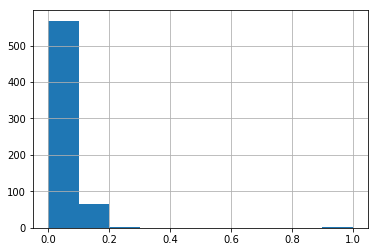

In [207]:
df_merged2.loc[192, "Weight"] = 0
df_merged2.loc[193, "Weight"] = 0

df_merged2["Pop Weight"] = df_merged2["Weight"] / df_merged2["Population"]
pw = df_merged2["Pop Weight"]
df_merged2["Pop Weight"] = (pw - pw.min()) / (pw.max() - pw.min())

df_merged2["Pop Weight"].hist()

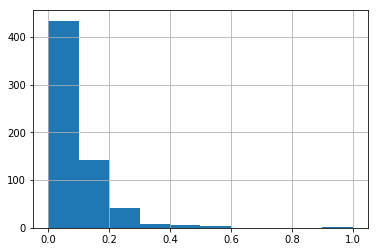

In [208]:

df_merged2["Area Weight"].hist()

## Generating the timelapse map

In [165]:

def get_color(weight):
    """ Makes red color weighted by weight between 0. and 1. """
    hexlet = ''.join([str(n) for n in range(10)]) + 'abcdef'
    idx = int(round(weight * 15))
    return '#' + hexlet[idx]*2 + '0000'

get_color(.03), get_color(.06), get_color(.93), get_color(.97)

('#000000', '#110000', '#ee0000', '#ff0000')

In [212]:

import folium
from folium import plugins
import copy


def features_for(key):
    df = df_merged2.copy()

    features = []

    for year in TIME_RANGE:
        print(year)
        for feature in nta_geo["features"]:
            ft = copy.deepcopy(feature)

            nta_code = ft["properties"]["ntacode"]
            df_ntacorrect = df[(df["NTA"] == nta_code) & (df["Year"] == year)]
            if not df_ntacorrect.empty:
                if df_ntacorrect.shape[0] != 1:
                    print("what?")
                color = get_color(df_ntacorrect.iloc[0][key])
            else:
                color = '#000000'

            ft["properties"]["style"] = {
                "fillColor": color,
                'weight' : 1,
                'fillOpacity' : 1, #0.66
                'stroke': False
            }
            ft["properties"]["time"] = str(year)

            features.append(ft)
    return features


In [214]:

m = folium.Map(location=(40.730610, -73.935242), zoom_start=10, tiles="Stamen Toner")

plugins.TimestampedGeoJson(
    {'type': 'FeatureCollection',
    'features': features_for("Weight")}
    , period='P1Y'
    , duration="P1Y"        
    , add_last_point=True
    , auto_play=False
    , loop=False
    , max_speed=0.5
    , loop_button=True
    , date_options='YYYY'
    , time_slider_drag_update=True
).add_to(m)

m.save("raw_weight.html")

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [215]:
del m

In [216]:

m = folium.Map(location=(40.730610, -73.935242), zoom_start=10, tiles="Stamen Toner")

plugins.TimestampedGeoJson(
    {'type': 'FeatureCollection',
    'features': features_for("Pop Weight")}
    , period='P1Y'
    , duration="P1Y"        
    , add_last_point=True
    , auto_play=False
    , loop=False
    , max_speed=0.5
    , loop_button=True
    , date_options='YYYY'
    , time_slider_drag_update=True
).add_to(m)

m.save("pop_weight.html")

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [217]:
del m

In [218]:

m = folium.Map(location=(40.730610, -73.935242), zoom_start=10, tiles="Stamen Toner")

plugins.TimestampedGeoJson(
    {'type': 'FeatureCollection',
    'features': features_for("Area Weight")}
    , period='P1Y'
    , duration="P1Y"        
    , add_last_point=True
    , auto_play=False
    , loop=False
    , max_speed=0.5
    , loop_button=True
    , date_options='YYYY'
    , time_slider_drag_update=True
).add_to(m)

m.save("area_weight.html")

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [219]:
del m

In [3]:
import pandas as pd
import json
import copy

def RGB_to_hex(RGB):
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
            "{0:x}".format(v) for v in RGB])


path_dsny = "data/dsny_ranking.pkl"
path_dsny_geo = "data/DSNY Districts.geojson"

RELEVANT_FEATURE = "Complaints per capita norm"

df_dsny = pd.read_pickle(path_dsny)
with open(path_dsny_geo) as fp:
    gj_dsny = json.load(fp)
gj_dsny


{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'districtcode': '311',
    'global_id': '857f750e-f050-472e-a3e8-449008357b98',
    'shape_area': '103176292.560593',
    'objectid': '1',
    'shape_length': '51566.6174119332',
    'district': 'BKS11'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-73.9729957711086, 40.6088223787093],
      [-73.9730323236089, 40.6090133438164],
      [-73.9734851673934, 40.6113792985499],
      [-73.9737074700836, 40.6125806091553],
      [-73.9739485254965, 40.6138041654075],
      [-73.9739946265932, 40.6140381321629],
      [-73.9740582258761, 40.614036732714],
      [-73.9741239694176, 40.6140214107539],
      [-73.974183833757, 40.6139914557672],
      [-73.9742299488845, 40.6139496990388],
      [-73.974257688674, 40.6139017705085],
      [-73.9742670425222, 40.6138538018363],
      [-73.9748943897363, 40.6131946067957],
      [-73.9749740788023, 40.6136763481225],
      [-73.9768282230708, 40.6147846

In [6]:

def get_features(df_source, gj, df_area_key, gj_area_key):
    df = df_source.copy()
    df.reset_index(inplace=True)
    features = []

    for year in range(2010, 2019):
        for feature in gj["features"]:
            ft = copy.deepcopy(feature)

            area = ft["properties"][gj_area_key]
            df_correct = df[(df[df_area_key] == area) & (df["Created Year"] == year)]

            q = df_correct.iloc[0][RELEVANT_FEATURE]\
                if df_correct.shape[0] > 0 else 0

            color = RGB_to_hex((255*q, 0, 255*(1-q)))        

            ft["properties"]["style"] = {
                "fillColor": str(color),
                'weight' : 1,
                'fillOpacity' : 0.66,
                'stroke': False
            }
            ft["properties"]["time"] = str(year)

            features.append(ft)
    return features


In [14]:

import folium
from folium import plugins
import branca
import branca.colormap as cm

def map_features(features, df, df_key, nom_vmin, nom_vmax):
    m = folium.Map(location=(40.730610, -73.935242), zoom_start=10, tiles="Stamen Toner")

    plugins.TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1Y'
        , duration="P1Y"        
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=0.5
        , loop_button=True
        , date_options='YYYY'
        , time_slider_drag_update=True
    ).add_to(m)

    vmin = df[df_key].min()
    vmax = df[df_key].max()
    print(vmin, vmax)
    colormap = cm.LinearColormap(colors=['blue', 'red'],
                                 index=[vmin*nom_vmin, vmax*nom_vmax],
                                 vmin=vmin*nom_vmin,
                                 vmax=vmax*nom_vmax)
    colormap.caption = df_key
    colormap.add_to(m)
    return m

## NYPD, Complaints per capita norm

In [28]:

df = pd.read_pickle("data/nypd_ranking.pkl")
with open("data/Police Precincts.geojson") as fp:
    gj = json.load(fp)
features = get_features(df, gj, df_area_key="District", gj_area_key="precinct")

m = map_features(features, df, "Complaints per capita norm", 0, 200)
m.save("nypd_Complaints per capita norm.html")

0.08287378780373032 0.999599717315996


## NYPD, Median resolution time (hours) norm

In [29]:

df = pd.read_pickle("data/nypd_ranking.pkl")
with open("data/Police Precincts.geojson") as fp:
    gj = json.load(fp)
features = get_features(df, gj, df_area_key="District", gj_area_key="precinct")

m = map_features(features, df, "Median resolution time (hours) norm", 0, 15)
m.save("nypd_Median resolution time (hours) norm.html")

0.06632407407407408 0.8741296296296296


## DSNY, Complaints per capita norm

In [30]:

df = pd.read_pickle("data/dsny_ranking.pkl")
with open("data/DSNY Districts.geojson") as fp:
    gj = json.load(fp)
features = get_features(df, gj, df_area_key="District", gj_area_key="districtcode")

m = map_features(features, df, "Complaints per capita norm", 0, 50)
m.save("dsny_Complaints per capita norm.html")

0.08585473946497321 0.920273043064163


## DSNY, Median resolution time (hours) norm

In [33]:

df = pd.read_pickle("data/dsny_ranking.pkl")
col = df["Median resolution time (hours) norm"]
_min, _max = col.min(), col.max()
df["Median resolution time (hours) norm"] = (col - _min) / (_max - _min)

with open("data/DSNY Districts.geojson") as fp:
    gj = json.load(fp)
features = get_features(df, gj, df_area_key="District", gj_area_key="districtcode")

m = map_features(features, df, "Median resolution time (hours) norm", 0, 15)
m.save("dsny_Median resolution time (hours) norm.html")

0.0 1.0


In [32]:
df

,,Mean resolution time (days),Median resolution time (days),Number of complaints,District population,Complaints per 1k capita,Complaints per capita norm,Median resolution time (hours),Median resolution time (hours) norm
District,Created Year,,,,,,,,
107,2012,3.901260,1.145833,861,200571.338371,4.292737,0.085855,27.500000,1.833333
205,2013,28.205429,1.938542,524,120788.208561,4.338172,0.086763,46.525000,3.101667
109,2012,10.774949,1.947222,505,113264.247086,4.458600,0.089172,46.733333,3.115556
108,2012,7.823667,1.172222,1103,219020.148785,5.036066,0.100721,28.133333,1.875556
109,2013,16.240500,2.930556,594,113264.247086,5.244373,0.104887,70.333333,4.688889
...,...,...,...,...,...,...,...,...,...
305,2018,9.365523,0.902083,6992,161010.237204,43.425810,0.868516,21.650000,1.443333
412,2018,6.249086,1.134722,9855,226720.063100,43.467701,0.869354,27.233333,1.815556
306,2016,8.268647,1.884028,4374,100470.181863,43.535305,0.870706,45.216667,3.014444
